In [129]:
#import import_ipynb
#import libraries_import # Bring in libraries
!pip install geopy
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import folium # map rendering library
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.model_selection import train_test_split

# Predicting Changing Neighborhoods

by Ben Straub - March 1st, 2021

## Introduction

### Background

Increasing rent in major cities is becoming an ever-present discussion of its ills.  The intersection of rents and the presence of **and/or** the coming presence of certain amenities could herald increased rents for neighborhoods.  My paper attempts to showcase a possible pipeline of publicly available rental data and Foursquare API data to better understand possible intersections of amenities and rent.  The pipeline will pre-process both datasets with the intention to merge them together into one datasets.  Once the pre-processing is complete, the final dataset will then be sent to a machine-learning model to enable predictions.

### Problem

My intention is to create a model that predicts rents in changing neighborhoods.  Using Foursquare data and publicly available rental data I will explore the intersection of rents and amenities.  I will provide a discussion on rents and amenities driven by exploratory data analyssis and attempt to build several predictive models that could be used to predict rental increases.  I am particularly interested in if the presence of certain amenities or sequence of amenities herald increased rents.  For example, an addition of a Yoga Studio will increase the the rent by X amount if the ABC amentities are present in the area. 

### Interest

Those involved in discussions around gentrification or neighborhood transition could gain greater insights into how the evolution of rent in neighborhoods could be driven by certain amenities.  City planners could also glean information from presentation of different models around the impact of amentities in an area of a city and make proper accomdations for residents/other businesses in that neighborhood, e.g. rent subsidies, tax abatements, etc.

#### Limitations
Two limitations of this paper are the dataset and the potental models.  The dataset is made up of two parts: Rental data and Foursquare API data -discussed below.  The Foursquare API limits the amount of queries that a non-paying member can make to its API.  This severely limits the dataset that I can create.  The phrase *Garbage In, Garbage Out* follows me in this paper.   Finally, my limited understanding of Machine Learning models also limits how much I can explore and implement properly.  At the end of my Capstone/Paper I was so exhausted from the data manipulation and merging that I did not have proper time to explore ML models.      

## Proposed Data Pipeline to Predtictive Model

1. Query Rental Data Source 
2. Clean Rental Data 
3. Identify Cities of Interest 
4. Use those Cities to query Foursquare API for Amenities 
5. Clean Foursquare Data 
6. Merge Rental and API Datasets  
7. Train/Test ML Model 
8. Gain insights and understanding from Model

This is my simple proposal to solve my problem statement.

## Data Acquisition, Cleaning and Exploratory Analysis

### Zillow Rental Data

I will need to collect data from two sources for my pipeline.  The first dataset is collected from Zillow available here: https://www.zillow.com/research/data/. For now, a user will have to go and download the dataset that is of interest to them.  However, Zillow does provide an API that could link into this pipeline.  This rental dataset that I have download has *2608* observations and *88* variables.  The first 4 identifying variables are the *MsaName* - Metropolitatn Name, *RegionID*, *RegionName* - Postal Code and a *SizeRank*.  The remaining 84 variables are the average rents for a particualr City and its ZipCode from January 2014 to January 2021. Postal Code, Zip Code and RegionName will be used throughout this paper, which are identify the same thing.  I intend to just look at a subset of these Cities.  How I arrive at my subset is discussed below.  

In [130]:
rental_data = pd.read_csv('data/Zip_ZORI_AllHomesPlusMultifamily_SSA.csv', index_col=3)
rental_data.head()

,RegionID,RegionName,SizeRank,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,...,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01
MsaName,,,,,,,,,,,,,,,,,,,,,
"New York, NY",61639,10025,1,"3,062.000","3,076.000","3,089.000","3,102.000","3,115.000","3,129.000","3,142.000",...,"3,277.000","3,232.000","3,188.000","3,144.000","3,098.000","3,052.000","3,006.000","2,958.000","2,910.000","2,861.000"
"Chicago, IL",84654,60657,2,"1,544.000","1,550.000","1,555.000","1,561.000","1,566.000","1,571.000","1,576.000",...,"1,778.000","1,771.000","1,765.000","1,758.000","1,751.000","1,743.000","1,736.000","1,728.000","1,721.000","1,713.000"
"New York, NY",61637,10023,3,"3,104.000","3,114.000","3,124.000","3,133.000","3,142.000","3,151.000","3,160.000",...,"3,233.000","3,190.000","3,148.000","3,106.000","3,061.000","3,017.000","2,973.000","2,927.000","2,880.000","2,834.000"
"Houston, TX",91982,77494,4,"1,738.000","1,741.000","1,744.000","1,748.000","1,751.000","1,754.000","1,757.000",...,"1,759.000","1,763.000","1,767.000","1,770.000","1,774.000","1,778.000","1,782.000","1,786.000","1,790.000","1,794.000"
"Chicago, IL",84616,60614,5,"1,702.000","1,707.000","1,712.000","1,717.000","1,721.000","1,726.000","1,731.000",...,"1,970.000","1,958.000","1,945.000","1,932.000","1,919.000","1,906.000","1,892.000","1,878.000","1,863.000","1,849.000"


#### Subsetting the Rental dataset will be done as follow :

* Calculate Row Medians for each City/Zip Code 
* Sort by descending
* Grab the City/Zip Code data for those with a Row Median of between 1,000 and 2,000 US dollars.
* Select Unique cities from dataset

In [131]:
rental_median = rental_data.median(axis=1)
type(rental_median)
rental_median_df = pd.DataFrame({'City, State':rental_median.index, 'Row Median':rental_median.values})
sorted_df = rental_median_df.sort_values(by='Row Median',ascending=False)
sorted_df = sorted_df.reset_index(drop=True)
rental_median_display = sorted_df.loc[1023:1026, ["City, State", "Row Median"]] 
rental_median_display

,"City, State",Row Median
1023,"Dallas-Fort Worth, TX","1,658.000"
1024,"Philadelphia, PA","1,658.000"
1025,"New York, NY","1,657.500"
1026,"Washington, DC","1,657.000"


#### Collecting unique cities

I select, a bit arbitrailly, row medians that are between 1000 and 2000 US dollars.  This is to ensure that I grab my hometown of Philadelphia, Pa.  I then select the unique cities that are available in my dataset that will be used to query the Foursquare API.  As this is just a demonstration of a pipelin, I think 10 cities is enough, but all cities could be piped into the Foursquare API.  The 10 cities will be put into a list and used to subset the Rental data. 

In [132]:
df_subset = sorted_df[(sorted_df['Row Median'] < 2000) & (sorted_df['Row Median'] > 1000)]
df_unique = df_subset['City, State'].unique()
df_city = pd.DataFrame(df_unique).iloc[19:29]
df_city.rename(columns={ df_city.columns[0]: "City, State" }, inplace = True)
my_city_list = df_city['City, State'].to_list()
pd.DataFrame(my_city_list).T

,0,1,2,3,4,5,6,7,8,9
0,"Atlanta, GA","Sacramento, CA","Phoenix, AZ","Philadelphia, PA","Charlotte, NC","Dallas-Fort Worth, TX","Ventura, CA","Providence, RI","Austin, TX","Tampa, FL"


#### Final Preperation of Rental Data

Now that the 10 above cities have been chosen, I will subset the rental data from **Zillow**.  This helps to make the demonstration of the potential pipeline a bit more manageable.  The Rental dataset has been reduced from *2608* observations and *88* variables to *575* observations and *88* variables.  This reduced dataset only includes my 10 cities of interest.  

In [133]:
rental_data_sub = pd.read_csv('data/Zip_ZORI_AllHomesPlusMultifamily_SSA.csv', index_col=0)
final_rental_df = rental_data_sub[rental_data_sub['MsaName'].isin(my_city_list)]
final_rental_df.head()
#final_rental_df.shape

,RegionName,SizeRank,MsaName,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,...,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01
RegionID,,,,,,,,,,,,,,,,,,,,,
92593,78660,13,"Austin, TX","1,313.000","1,317.000","1,322.000","1,326.000","1,331.000","1,335.000","1,340.000",...,"1,581.000","1,583.000","1,585.000","1,586.000","1,588.000","1,590.000","1,592.000","1,594.000","1,596.000","1,598.000"
69816,28269,34,"Charlotte, NC","1,157.000","1,161.000","1,164.000","1,168.000","1,171.000","1,175.000","1,179.000",...,"1,531.000","1,542.000","1,553.000","1,565.000","1,576.000","1,588.000","1,599.000","1,611.000","1,623.000","1,635.000"
92551,78613,35,"Austin, TX","1,269.000","1,274.000","1,279.000","1,284.000","1,289.000","1,294.000","1,299.000",...,"1,515.000","1,516.000","1,517.000","1,518.000","1,518.000","1,519.000","1,519.000","1,520.000","1,520.000","1,520.000"
71067,30349,38,"Atlanta, GA",959.000,961.000,963.000,965.000,967.000,969.000,971.000,...,"1,330.000","1,343.000","1,356.000","1,370.000","1,383.000","1,396.000","1,410.000","1,423.000","1,437.000","1,451.000"
90654,75052,40,"Dallas-Fort Worth, TX","1,104.000","1,109.000","1,113.000","1,118.000","1,122.000","1,126.000","1,130.000",...,"1,468.000","1,473.000","1,479.000","1,484.000","1,490.000","1,496.000","1,501.000","1,507.000","1,513.000","1,519.000"


#### Exploring the 10 cities rental data

Here I make brief exploration of the rental data using some plots from `matplotlib`.  The rental data will need to converted from the wide format to the long format.  Conversion will help to make displaying the rental data plot easier.  I make use of the `pd.melt` function.  The small dataset that was `5x88` will be tranposed to a `4x48300` dataset. This is also referred to as converting from wide to long and you can see it in action from 88 to 48300!  I will take a look at the first three zip codes for my 10 cities to see if there is anything to learn from the rental data.

In [134]:
months_yrs = list(final_rental_df.columns)[4:88]
# use pd.melt to convert to long data. 
df_long = pd.melt(final_rental_df, id_vars = ['RegionName', 'MsaName'], value_vars = months_yrs)
df_long.head(10)


,RegionName,MsaName,variable,value
0,78660,"Austin, TX",2014-02,"1,317.000"
1,28269,"Charlotte, NC",2014-02,"1,161.000"
2,78613,"Austin, TX",2014-02,"1,274.000"
3,30349,"Atlanta, GA",2014-02,961.000
4,75052,"Dallas-Fort Worth, TX",2014-02,"1,109.000"
5,30044,"Atlanta, GA",2014-02,"1,033.000"
6,28277,"Charlotte, NC",2014-02,"1,398.000"
7,30043,"Atlanta, GA",2014-02,"1,141.000"
8,30096,"Atlanta, GA",2014-02,"1,214.000"
9,30024,"Atlanta, GA",2014-02,"1,378.000"


In [135]:
def get_city(x):
    sac= df_long[df_long.MsaName == x]
    sac_unique = sac['RegionName'].unique()
    #return(sac_unique)
    sac_subset_1 = df_long[(df_long['RegionName'] == sac_unique[0]) & (df_long['MsaName'] == x)]
    return(sac_subset_1)

atl = get_city('Atlanta, GA')
sac = get_city('Sacramento, CA')
phx = get_city('Phoenix, AZ')
phl = get_city('Philadelphia, PA')
cht = get_city('Charlotte, NC')
dal = get_city('Dallas-Fort Worth, TX')
pro = get_city('Providence, RI')
aus = get_city('Austin, TX')
tam = get_city('Tampa, FL')
ven = get_city('Ventura, CA')

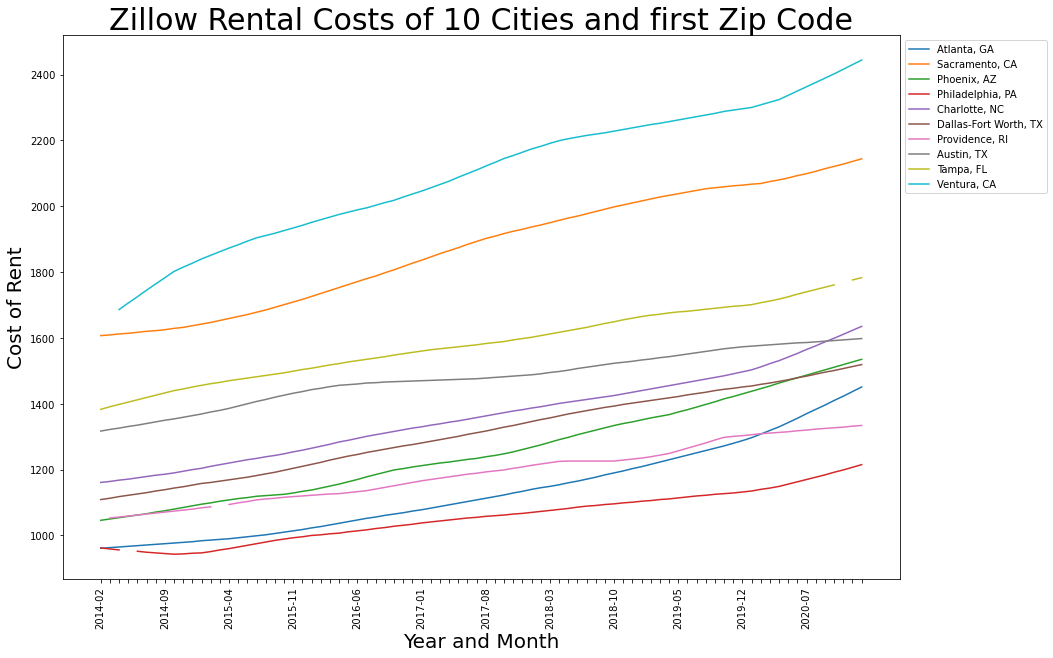

In [136]:
plt.figure(figsize=(15,10))
plt.plot(atl.variable, atl.value, label="Atlanta, GA")
plt.plot(sac.variable, sac.value, label="Sacramento, CA")
plt.plot(phx.variable, phx.value, label="Phoenix, AZ")
plt.plot(phl.variable, phl.value, label="Philadelphia, PA")
plt.plot(cht.variable, cht.value, label="Charlotte, NC")
plt.plot(dal.variable, dal.value, label="Dallas-Fort Worth, TX")
plt.plot(pro.variable, pro.value, label="Providence, RI")
plt.plot(aus.variable, aus.value, label="Austin, TX")
plt.plot(tam.variable, tam.value, label="Tampa, FL")
plt.plot(ven.variable, ven.value, label="Ventura, CA")
plt.xlabel('Year and Month', fontsize=20)
plt.ylabel('Cost of Rent', fontsize=20)
plt.title('Zillow Rental Costs of 10 Cities and first Zip Code', fontsize=30)
plt.xticks(rotation=90)
ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::7]))
for label in temp:
    label.set_visible(False)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [137]:
def get_city(x):
    sac= df_long[df_long.MsaName == x]
    sac_unique = sac['RegionName'].unique()
    #return(sac_unique)
    sac_subset_1 = df_long[(df_long['RegionName'] == sac_unique[2]) & (df_long['MsaName'] == x)]
    return(sac_subset_1)

atl = get_city('Atlanta, GA')
sac = get_city('Sacramento, CA')
phx = get_city('Phoenix, AZ')
phl = get_city('Philadelphia, PA')
cht = get_city('Charlotte, NC')
dal = get_city('Dallas-Fort Worth, TX')
pro = get_city('Providence, RI')
aus = get_city('Austin, TX')
tam = get_city('Tampa, FL')
ven = get_city('Ventura, CA')

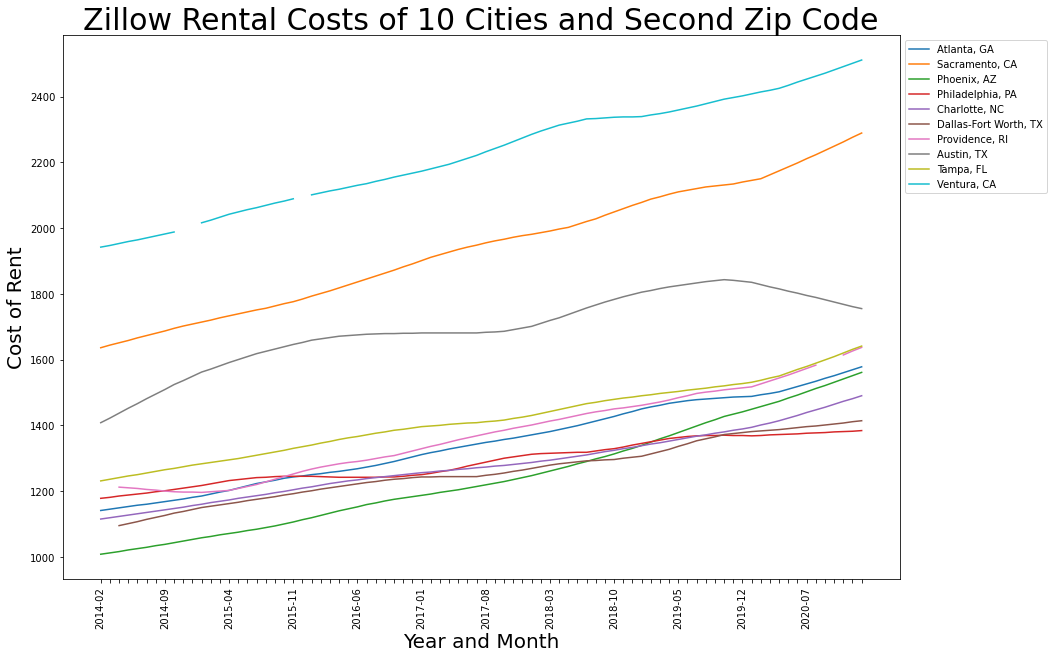

In [138]:
plt.figure(figsize=(15,10))
plt.plot(atl.variable, atl.value, label="Atlanta, GA")
plt.plot(sac.variable, sac.value, label="Sacramento, CA")
plt.plot(phx.variable, phx.value, label="Phoenix, AZ")
plt.plot(phl.variable, phl.value, label="Philadelphia, PA")
plt.plot(cht.variable, cht.value, label="Charlotte, NC")
plt.plot(dal.variable, dal.value, label="Dallas-Fort Worth, TX")
plt.plot(pro.variable, pro.value, label="Providence, RI")
plt.plot(aus.variable, aus.value, label="Austin, TX")
plt.plot(tam.variable, tam.value, label="Tampa, FL")
plt.plot(ven.variable, ven.value, label="Ventura, CA")
plt.xlabel('Year and Month', fontsize=20)
plt.ylabel('Cost of Rent', fontsize=20)
plt.title('Zillow Rental Costs of 10 Cities and Second Zip Code', fontsize=30)
plt.xticks(rotation=90)
ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::7]))
for label in temp:
    label.set_visible(False)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

In [139]:
def get_city(x):
    sac= df_long[df_long.MsaName == x]
    sac_unique = sac['RegionName'].unique()
    #return(sac_unique)
    sac_subset_1 = df_long[(df_long['RegionName'] == sac_unique[2]) & (df_long['MsaName'] == x)]
    return(sac_subset_1)

atl = get_city('Atlanta, GA')
sac = get_city('Sacramento, CA')
phx = get_city('Phoenix, AZ')
phl = get_city('Philadelphia, PA')
cht = get_city('Charlotte, NC')
dal = get_city('Dallas-Fort Worth, TX')
pro = get_city('Providence, RI')
aus = get_city('Austin, TX')
tam = get_city('Tampa, FL')
ven = get_city('Ventura, CA')

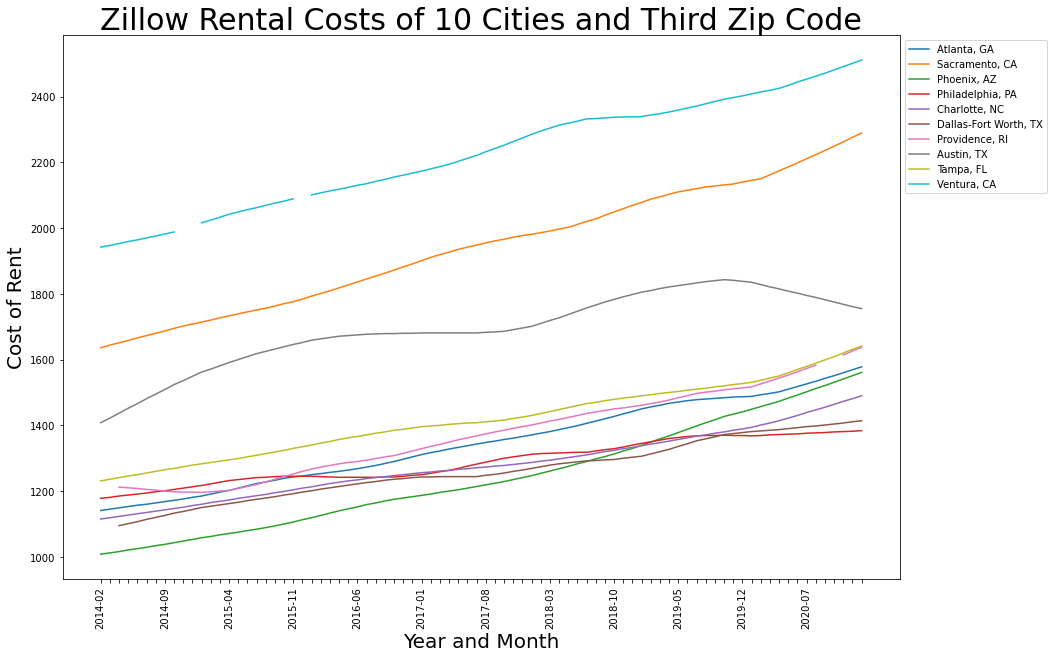

In [140]:
plt.figure(figsize=(15,10))
plt.plot(atl.variable, atl.value, label="Atlanta, GA")
plt.plot(sac.variable, sac.value, label="Sacramento, CA")
plt.plot(phx.variable, phx.value, label="Phoenix, AZ")
plt.plot(phl.variable, phl.value, label="Philadelphia, PA")
plt.plot(cht.variable, cht.value, label="Charlotte, NC")
plt.plot(dal.variable, dal.value, label="Dallas-Fort Worth, TX")
plt.plot(pro.variable, pro.value, label="Providence, RI")
plt.plot(aus.variable, aus.value, label="Austin, TX")
plt.plot(tam.variable, tam.value, label="Tampa, FL")
plt.plot(ven.variable, ven.value, label="Ventura, CA")
plt.xlabel('Year and Month', fontsize=20)
plt.ylabel('Cost of Rent', fontsize=20)
plt.title('Zillow Rental Costs of 10 Cities and Third Zip Code', fontsize=30)
plt.xticks(rotation=90)
ax = plt.gca()
temp = ax.xaxis.get_ticklabels()
temp = list(set(temp) - set(temp[::7]))
for label in temp:
    label.set_visible(False)
plt.legend(bbox_to_anchor=(1,1), loc="upper left")
plt.show()

#### Rental Data Conclusion

The data for my 10 cities and their repsective zip codes shows a steady increase in rent over time.  Ventura and Sacremento, CA show huge increases over time while most other cities show a steady increase.  Something to note is that Austin, TX in one zip code shows a decrease in rent and in Philadelphia, Pa there apepars to be no increase for mid-2019-2020.  This is not a rigorous discussion on rental increases of my 10 cities, but I have feeling that all of these same plots would show a mostly steady increase in rent over time in cities.  Also, please note that blanks in the lines plots mean that there is missing data fro that month.

### Foursquare API Data

Now I will make use of the **Foursquare API** data that was presented in the **IBM Data Science Specialization (DSS)**.  To get API data from Foursqaure using my 10 cities I will do the following:

* Append United, States to the end each entry of my city list
* Use that list to query each location through the `geocode` library
* Use coordinates to query Foursquare for amenities data
* Tidy the data using the functions from the **IBM DSS**
* **NOTE:**  I make use of the postal code from the API data, so the **IBM DSS** code is slightly modified.
* The use of the postal (zip) code will make it easier to merge the datasets together.

#### Querying geocode to get coordinates

In [141]:
# Append United, States to my city list.
my_city_list
append_str = ', United States'
suf_res = [sub + append_str for sub in my_city_list] 

# Find location data for each Point of Interest
def find_loc(address):
    geolocator = Nominatim(user_agent="to_explorer")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    print(address, 'is located at', latitude, longitude)
    #map_city= folium.Map(location=[latitude, longitude], zoom_start=12)
    #return(map_city)

print("")
print("10 Cities with latitude and longitude coordinates:")
print("")
for i in suf_res:
    find_loc(i)


10 Cities with latitude and longitude coordinates:

Atlanta, GA, United States is located at 33.7489924 -84.3902644
Sacramento, CA, United States is located at 38.5810606 -121.4938951
Phoenix, AZ, United States is located at 33.4484367 -112.0741417
Philadelphia, PA, United States is located at 39.9527237 -75.1635262
Charlotte, NC, United States is located at 35.2272086 -80.8430827
Dallas-Fort Worth, TX, United States is located at 32.7476308 -97.3135971
Ventura, CA, United States is located at 34.4458248 -119.0779359
Providence, RI, United States is located at 41.8239891 -71.4128343
Austin, TX, United States is located at 30.2711286 -97.7436995
Tampa, FL, United States is located at 27.9477595 -82.458444


#### Querying Foursquare to get coordinates

I was not able to figure out how to programatically port in the city coordinataes.  However, I know that this can be done, which would allow a user to tailor their report to any set of cities that they might be interested in exploring.

In [142]:
CLIENT_ID = '4KCZQIWP2C3DCADJSJDFHDXE1NWQEGV5MADYDVVSAN3CKYK0' # your Foursquare ID
CLIENT_SECRET = 'C31NBUPKLN1SHGFL32Z55LIDNHNLNA5PQDRQC2N1LPF1JKLK' # your Foursquare Secret
ACCESS_TOKEN = 'Z44MRGHEWGI000AZY1I0CINVYPDNLS1CI54W003YTKO1M3ZG' # your FourSquare Access Token
LIMIT = 10000 # A default Foursquare API limit value
VERSION = '20180604'
radius = 10000 # define radius

def get_4sqr_data(lat, long):
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat,
        long,
        radius, 
        LIMIT)
    results = requests.get(url).json() # Print suppressed as its massive unwieldy file!
    return(results)

# Get the result to a json file
atl_4sqr = get_4sqr_data(33.7489924, -84.3902644)
sac_4sqr = get_4sqr_data(38.5810606, -121.4938951)
phx_4sqr = get_4sqr_data(33.4484367, -112.0741417)
phl_4sqr = get_4sqr_data(39.9527237, -75.1635262)
cht_4sqr = get_4sqr_data(35.2272086, -80.8430827)
dal_4sqr = get_4sqr_data(32.7476308, -97.3135971)
veb_4sqr = get_4sqr_data(34.4458248, -119.0779359)
prov_4sqr = get_4sqr_data(41.8239891, -71.4128343)
aus_4sqr = get_4sqr_data(30.2711286, -97.7436995)
tamp_4sqr = get_4sqr_data(27.9477595, -82.458444)

Here is peek at JSON file and the additional information I am pulling out to help make merging easier

![alt text](imgs/postal.PNG "Final Dataframe for Part 2")

Here I make use of the **IBM Data Science Specialization** with slight modifications.  Since I would like to bring in multiple cities at once, I made a function called `get_pretty`, which is the code from class, but just functionalized.  Again, a limitation is that the cities are not cleaned up in a more programmtic fashion.  For example, I call the function 10 times, but I know that this not good programming practice!    

In [143]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

def get_pretty(results):
    venues = results['response']['groups'][0]['items']
    nearby_venues = json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng', 'venue.location.postalCode']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    return(nearby_venues)

atl_final = get_pretty(atl_4sqr)
sac_final = get_pretty(sac_4sqr)
phx_final = get_pretty(phx_4sqr)
phl_final = get_pretty(phl_4sqr)
cht_final = get_pretty(cht_4sqr) 
dal_final = get_pretty(dal_4sqr)
veb_final = get_pretty(veb_4sqr)
prov_final = get_pretty(prov_4sqr)
aus_final = get_pretty(aus_4sqr)
tamp_final = get_pretty(tamp_4sqr)

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


#### Combine all results

Here I am going to combine all the results from my 10 calls to my `get_pretty` function.  I have to remove some undesirable `nan's` and a few incomplete zip codes. I am left with a dataframe that is `5x909`.  Looks like I lost about 90 observations in the clean up.  I will now count the number of categories within the combinded dataset as well as the number of zipcodes.  Counts for both are dispalyed as tables as well as in bar plots.  Data is subsetted to show only counts greater than 10 to ease viewing. The first dataset is the raw 909 observations.

In [144]:
all_dfs = [atl_final, sac_final, phx_final, phl_final, cht_final, dal_final, veb_final, prov_final, aus_final, tamp_final]
final_4sqr = pd.concat(all_dfs).reset_index(drop=True)
final_4sqr

,name,categories,lat,lng,postalCode
0,Wine Shoe,Wine Shop,33.752,-84.399,30313
1,Mercedes-Benz Stadium,Football Stadium,33.755,-84.401,30313
2,The Tabernacle,Music Venue,33.759,-84.391,30303
3,Aviva by Kameel,Mediterranean Restaurant,33.761,-84.387,30303
4,Grindhouse Killer Burgers,Burger Joint,33.754,-84.380,30303
...,...,...,...,...,...
904,Miguelitos,Mexican Restaurant,27.945,-82.488,33609
905,Popeyes Louisiana Kitchen,Fried Chicken Joint,27.957,-82.485,33607
906,Rollin Oats Market & Cafe,Health Food Store,27.953,-82.492,33607
907,Alessi Bakery & Deli,Sandwich Place,27.952,-82.490,33609


In [145]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

cat_look = pd.DataFrame(final_4sqr['categories'].value_counts())
cat_look['Types'] = cat_look.index
cat_look = cat_look[(cat_look['categories'] > 10 )]
cat_look.reset_index(drop=True, inplace=True)
df1 = cat_look.head(15)

zip_look = pd.DataFrame(final_4sqr['postalCode'].value_counts())
zip_look['Types'] = zip_look.index
zip_look = zip_look[(zip_look['postalCode'] > 10 )]
zip_look.reset_index(drop=True, inplace=True)
df2 = zip_look.head(15)

display_side_by_side([df1, df2], ['Type of Amenity in 10 Cities: Count > 10', 'Zip Codes of 10 Cities: Count > 10'])

,categories,Types
0,46,Coffee Shop
1,41,Mexican Restaurant
2,40,American Restaurant
3,31,Park
4,31,Pizza Place
5,28,Brewery
6,25,Hotel
7,23,New American Restaurant
8,20,Italian Restaurant
9,20,Bar


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing the pad parameter of tight_layout() positionally is deprecated since Matplotlib 3.3; the parameter will become keyword-only two minor releases later.


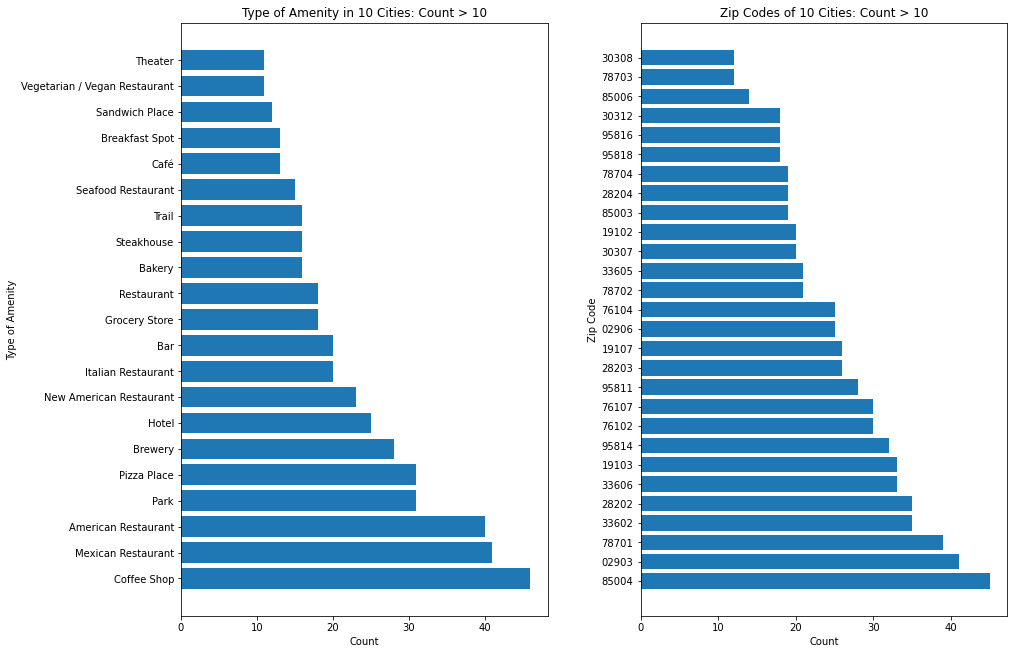

In [146]:
plt.figure(figsize=(15,10))
plt.subplot(1, 2, 1)  # row 1, column 2, count 1 
plt.barh(cat_look.Types, cat_look.categories)
plt.title('Type of Amenity in 10 Cities: Count > 10') 
plt.xlabel('Count') 
plt.ylabel('Type of Amenity') 
  
# using subplot function and creating plot two 
# row 1, column 2, count 2 
plt.subplot(1, 2, 2) 
  
# g is gor green color 
plt.barh(zip_look.Types, zip_look.postalCode)
plt.title('Zip Codes of 10 Cities: Count > 10') 
plt.xlabel('Count') 
plt.ylabel('Zip Code') 
  
# spce between the plots 
plt.tight_layout(4) 
  
# show plot 
plt.show()

The first two bar plots show that Coffe Shops are a dominant feautre with American and Mexican Restaurants a close second and third.  Parks also make it into the top 5.  For zip codes, the dominant one is *85004*, which is is Phoenix, Arizona and *02903*, which is Providence, Rhode Island.  I attmpted to showcase a count by amenities and zip code, but the sparsity of the dataset caused it to be not a great display.  This **sparsity** will cause issues later on for modeling.

#### Combine Rental and Foursquare data

This is the final step.  Combine the Zillow Rental data and the Foursquare API data.  There are a few more pre-processing steps to remove some issues and renaming of variables to effect a clean join.  Another issue, is that I only want to bring in rental data for which I have API data collected for.  Some of the zip codes for my 10 citits are not present in my current dataset.  

Final steps before model exploration:
* Remove any `nan` or incomplete zip codes
* Make sure zip codes are all numeric values.
* Rename columns to ensure easy join
* Use unqiue zip codes to pull out rental data that has API calls

In [147]:
# Getting unique zip codes and removing issues
zips_unique = final_4sqr['postalCode'].unique()
cleanedzip1 = [x for x in zips_unique if str(x) != 'nan']
cleanedzip2 = [x for x in cleanedzip1 if str(x) != '33606-1534']
cleanedzip2
res = list(map(int, cleanedzip2))

In [148]:
rental_data_4sqr = pd.read_csv('data/Zip_ZORI_AllHomesPlusMultifamily_SSA.csv', index_col=0)
final_rental_df = rental_data_4sqr[rental_data_4sqr['RegionName'].isin(res)]
final_rental_df.rename(columns={'RegionName': 'Zip Code'}, inplace=True)
final_rental_df.head()

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Zip Code,SizeRank,MsaName,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,...,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01
RegionID,,,,,,,,,,,,,,,,,,,,,
92617,78704,72,"Austin, TX","1,393.000","1,408.000","1,422.000","1,437.000","1,452.000","1,466.000","1,481.000",...,"1,815.000","1,808.000","1,802.000","1,795.000","1,789.000","1,782.000","1,775.000","1,768.000","1,761.000","1,755.000"
71038,30318,162,"Atlanta, GA",904.000,918.000,931.000,944.000,958.000,971.000,984.000,...,"1,439.000","1,438.000","1,436.000","1,434.000","1,432.000","1,430.000","1,428.000","1,426.000","1,425.000","1,423.000"
69768,28205,401,"Charlotte, NC",921.000,927.000,934.000,940.000,946.000,952.000,959.000,...,"1,377.000","1,378.000","1,379.000","1,380.000","1,381.000","1,382.000","1,383.000","1,383.000","1,384.000","1,385.000"
94724,85008,533,"Phoenix, AZ",719.000,720.000,722.000,723.000,725.000,727.000,729.000,...,"1,135.000","1,140.000","1,145.000","1,150.000","1,155.000","1,160.000","1,165.000","1,170.000","1,175.000","1,181.000"
65813,19146,729,"Philadelphia, PA","1,410.000","1,413.000","1,417.000","1,421.000","1,424.000","1,427.000","1,431.000",...,"1,685.000","1,685.000","1,685.000","1,685.000","1,685.000","1,685.000","1,685.000","1,685.000","1,685.000","1,685.000"


In [149]:
final_4sqr.rename(columns={'postalCode': 'Zip Code'}, inplace=True)
final_4sqr.drop(index=final_4sqr[final_4sqr['Zip Code'] == '33606-1534'].index, inplace=True)
final_4sqr['Zip Code'] = pd.to_numeric(final_4sqr['Zip Code'])
final_4sqr.head()

,name,categories,lat,lng,Zip Code
0,Wine Shoe,Wine Shop,33.752,-84.399,"30,313.000"
1,Mercedes-Benz Stadium,Football Stadium,33.755,-84.401,"30,313.000"
2,The Tabernacle,Music Venue,33.759,-84.391,"30,303.000"
3,Aviva by Kameel,Mediterranean Restaurant,33.761,-84.387,"30,303.000"
4,Grindhouse Killer Burgers,Burger Joint,33.754,-84.380,"30,303.000"


In [150]:
rental_4sqr_merged = pd.merge(final_4sqr, final_rental_df)
rental_4sqr_merged['Zip Code'] = rental_4sqr_merged['Zip Code'].dropna().apply(np.int64)
rental_4sqr_merged.head(10)


,name,categories,lat,lng,Zip Code,SizeRank,MsaName,2014-01,2014-02,2014-03,...,2020-04,2020-05,2020-06,2020-07,2020-08,2020-09,2020-10,2020-11,2020-12,2021-01
0,Nick's Food To Go,Greek Restaurant,33.747,-84.380,30312,2635,"Atlanta, GA","1,101.000","1,111.000",nan,...,"1,653.000","1,650.000","1,647.000","1,643.000","1,640.000","1,637.000","1,633.000","1,630.000","1,626.000","1,623.000"
1,Wood’s Chapel BBQ,BBQ Joint,33.737,-84.385,30312,2635,"Atlanta, GA","1,101.000","1,111.000",nan,...,"1,653.000","1,650.000","1,647.000","1,643.000","1,640.000","1,637.000","1,633.000","1,630.000","1,626.000","1,623.000"
2,Oakland Cemetery,Cemetery,33.748,-84.373,30312,2635,"Atlanta, GA","1,101.000","1,111.000",nan,...,"1,653.000","1,650.000","1,647.000","1,643.000","1,640.000","1,637.000","1,633.000","1,630.000","1,626.000","1,623.000"
3,Dr Martin Luther King Jr National Historic Site,Historic Site,33.756,-84.373,30312,2635,"Atlanta, GA","1,101.000","1,111.000",nan,...,"1,653.000","1,650.000","1,647.000","1,643.000","1,640.000","1,637.000","1,633.000","1,630.000","1,626.000","1,623.000"
4,Ria's Bluebird,Breakfast Spot,33.747,-84.374,30312,2635,"Atlanta, GA","1,101.000","1,111.000",nan,...,"1,653.000","1,650.000","1,647.000","1,643.000","1,640.000","1,637.000","1,633.000","1,630.000","1,626.000","1,623.000"
5,Grant Park,Park,33.738,-84.373,30312,2635,"Atlanta, GA","1,101.000","1,111.000",nan,...,"1,653.000","1,650.000","1,647.000","1,643.000","1,640.000","1,637.000","1,633.000","1,630.000","1,626.000","1,623.000"
6,Chrome Yellow Trading Co,Café,33.754,-84.371,30312,2635,"Atlanta, GA","1,101.000","1,111.000",nan,...,"1,653.000","1,650.000","1,647.000","1,643.000","1,640.000","1,637.000","1,633.000","1,630.000","1,626.000","1,623.000"
7,Six Feet Under Pub & Fish House,Seafood Restaurant,33.747,-84.373,30312,2635,"Atlanta, GA","1,101.000","1,111.000",nan,...,"1,653.000","1,650.000","1,647.000","1,643.000","1,640.000","1,637.000","1,633.000","1,630.000","1,626.000","1,623.000"
8,Firepit Pizza Tavern,Pizza Place,33.746,-84.371,30312,2635,"Atlanta, GA","1,101.000","1,111.000",nan,...,"1,653.000","1,650.000","1,647.000","1,643.000","1,640.000","1,637.000","1,633.000","1,630.000","1,626.000","1,623.000"
9,Agave,Mexican Restaurant,33.748,-84.368,30312,2635,"Atlanta, GA","1,101.000","1,111.000",nan,...,"1,653.000","1,650.000","1,647.000","1,643.000","1,640.000","1,637.000","1,633.000","1,630.000","1,626.000","1,623.000"


#### Conclusion for Data Acqusition, Cleaning and Exploratory Analysis

The final dataset is `5x92`.  Here we have the rental data combined with the foursquare data.  You can now see the amenities associated with zip code and its corresponding rents from **2014-2020**.  Unfortunately, this dataset is sparse for our modeling purposes.  

To summarize.  I have taken two datasets from public sources: Zillow rental data and Foursquare API data.  The rental came in as a csv file, was cleand and manipulated to draw out which cities to look at.  The choices of cities from the rental data then fed into the Foursquare API to draw out amentities on the cities.  These were then combined to one final dataset that could, in theory, be fed into a predictive/ML model.  The purpose of the model is to take in a training dataset and build a model and then evaluate that model on the test dataset. A person using this model could make predictions on what amentities could cause increases in rent based on the historical combined data.  The next section of this paper will attempt this feat. 

## Predictive Modeling

The combined dataset will now be used to build a simple model.  This presents a lot of limitations for the approach.  The dataset is sparse and not well-balanced.  I have also arbitrally decided on rules for selecting the cities of interest.  All these will lead to an imperfect and poor model.  However, this is just a fun paper for exploring potential ideas and concepts.  So I would be remiss if I did make an attempt at some form of Predictive Modeling.  Therefore, I make use of the Classical Linear Model for Predictive Model

I will need to do some pre-processing to the data before I can port it into a model:

1) Convert final dataset from wide to long
2) Separate out data for Response (y) and Covariates (X)
3) Dummy Encode the categorical dataset.

In [174]:
rental_4sqr_201401 = rental_4sqr_merged[['categories', 'MsaName', "2014-01"]]
rental_4sqr_201401 = rental_4sqr_201401.dropna()

In [177]:
X = rental_4sqr_201401[['categories', 'MsaName', ]]
Y = rental_4sqr_201401['2014-01']
X = pd.get_dummies(data=X, drop_first=True)
X.head()

,categories_Art Gallery,categories_Art Museum,categories_Asian Restaurant,categories_Athletics & Sports,categories_BBQ Joint,categories_Bagel Shop,categories_Bakery,categories_Bar,categories_Baseball Stadium,categories_Basketball Stadium,...,categories_Wine Shop,categories_Yoga Studio,"MsaName_Austin, TX","MsaName_Charlotte, NC","MsaName_Dallas-Fort Worth, TX","MsaName_Philadelphia, PA","MsaName_Phoenix, AZ","MsaName_Providence, RI","MsaName_Sacramento, CA","MsaName_Tampa, FL"
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [185]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = .20, random_state = 40)
pd.set_option('display.max_rows', None)
regr = linear_model.LinearRegression() # Do not use fit_intercept = False if you have removed 1 column after dummy encoding
regr.fit(X_train, Y_train)
predicted = regr.predict(X_test)
df = pd.DataFrame({'Actual': Y_test, 'Predicted': predicted})
df.head(20)

,Actual,Predicted
245,"1,385.000","-10,041,257,688,833,512.000"
76,904.000,"1,126.296"
26,"1,335.000","1,082.202"
212,"1,410.000","1,825.702"
395,"1,047.000","1,227.452"
363,"1,248.000","1,192.452"
4,"1,101.000","1,097.556"
325,921.000,"1,089.640"
316,921.000,"1,153.671"
298,"1,022.000","1,160.296"


In [184]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(df.Actual, df.Predicted))
print('Mean Squared Error:', metrics.mean_squared_error(df.Actual, df.Predicted))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(df.Actual, df.Predicted)))

Mean Absolute Error: 803707631351180.8
Mean Squared Error: 7.680006833905861e+30
Root Mean Squared Error: 2771282525096613.5


As expected the Simple Linear Model does a terrible job of prediction on the test set.  Obviously this is a terrible model choice for this type of dataset!  Unfortunately, I ran out of time to discover or implement other models on this dataset to see if the prediction could be improved.   

## Conclusions and Future Work

The dataset I choose to produce for this paper gave me a lot great practice for working with Python `pandas` and opportunites to test out `matplotlib`.  I was hoping that my the final dataset would give me an opportunity to explore a suite of ML Models.  Due to the limitations of the API and my poor final dataset I was not able to explore ML Models more in depth.  Honestly, once I got all my data together I was a bit unsure of how to even attack the problem with a model.  The dataset is time series based with several categorical predictors.  Phew!  Way over my head.  It seemed so interesting when I wrote it down the first time for my problem statement, but once I got it into a working condition it was way over my head.  

For future work, I would hope that increasing the size of the dataset and understanding before hand the types of models to explore for the dataset would lead to better outcome!
